# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
import cv2 # for img conversiont 
from sklearn.metrics import mean_squared_error


# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


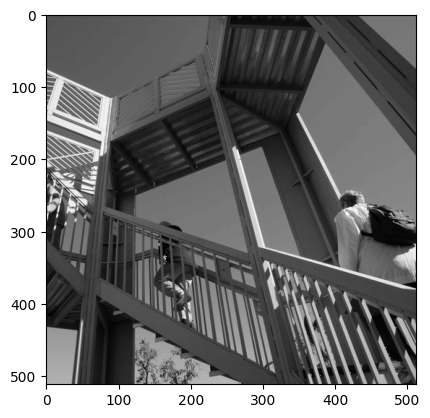

In [2]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

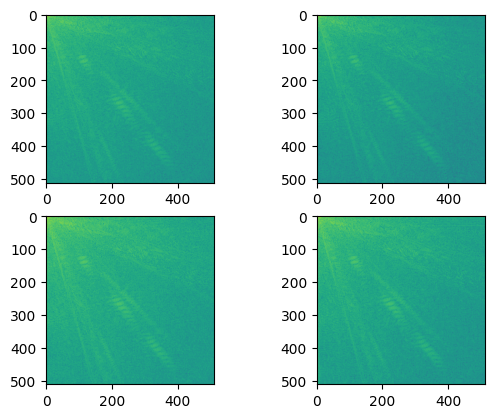

In [3]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

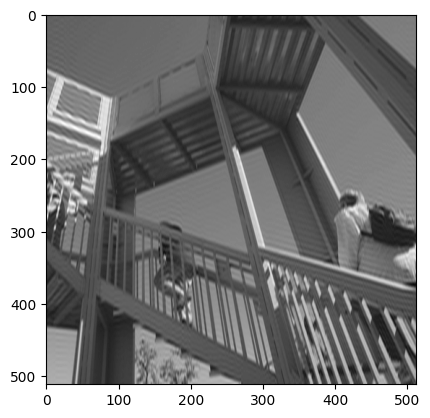

In [4]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

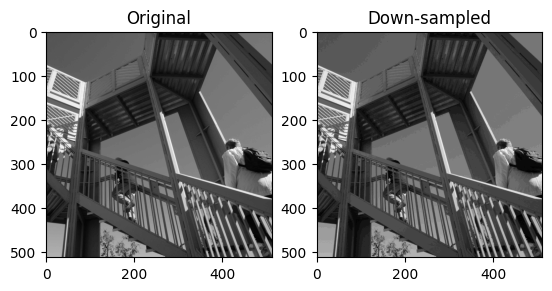

In [5]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down)

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

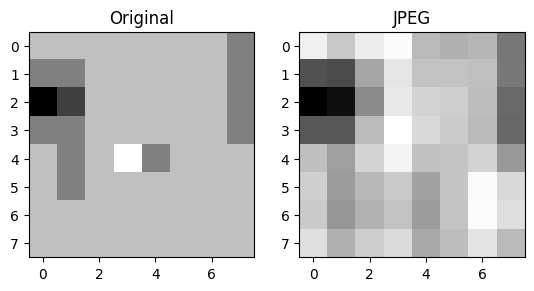

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [6]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]
block_size= 8

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

## Wrapper class for encoding an image

In [7]:
class JpegEncoder:
    compression = 15

    @staticmethod
    def set_compression(comp):
        assert 0 <= comp <= 2 * block_size - 1
        JpegEncoder.compression = 15 - comp

    @staticmethod
    def zigzag(block):
        rows, cols = block_size, block_size
        result = np.empty(rows * cols, dtype=block.dtype)
        i = 0
        
        for d in range(rows + cols - 1):
            if d % 2 == 0:
                for row in range(max(0, d - cols + 1), min(rows, d + 1)):
                    result[i] = block[row, d - row]
                    i += 1
            else:
                for col in range(max(0, d - rows + 1), min(cols, d + 1)):
                    result[i] = block[d - col, col]
                    i += 1
        
        return result
    
    @staticmethod
    def jpeg_block(block):
        assert block.shape == (block_size, block_size)
        y = dctn(block)
        y_jpeg = np.round(y / Q_jpeg)
        i, j = np.indices(y_jpeg.shape)
        mask = (i + j) >= JpegEncoder.compression
        y_jpeg[mask] = 0
        return y_jpeg

    @staticmethod
    def partition_array(arr, ):
        pad_height = (-arr.shape[0]) % block_size
        pad_width = (-arr.shape[1]) % block_size
        padded_arr = np.pad(arr, ((0, pad_height), (0, pad_width)), mode='constant')

        new_shape = (
            padded_arr.shape[0] // block_size, block_size,
            padded_arr.shape[1] // block_size, block_size
        )
        return padded_arr.reshape(new_shape).swapaxes(1, 2)

    @staticmethod
    def jpeg_block_img(block_img):
        jpeg = np.vectorize(JpegEncoder.jpeg_block, signature=f'({block_size},{block_size})->({block_size},{block_size})')
        zigzag = np.vectorize(JpegEncoder.zigzag, signature=f'({block_size},{block_size})->({block_size * block_size})')
        return zigzag(jpeg(block_img))

    @staticmethod
    def jpeg_encode(img):
        block_img = JpegEncoder.partition_array(img)
        return JpegEncoder.jpeg_block_img(block_img)

    @staticmethod
    def rgb_to_ycbcr(rgb_image):
        return cv2.cvtColor(rgb_image, cv2.COLOR_RGB2YCR_CB)

    @staticmethod
    def jpeg_rgb(img):
        ycbcr = JpegEncoder.rgb_to_ycbcr(img)
        assert img.shape[2] == 3
        jpeg_channels = [JpegEncoder.jpeg_encode(ycbcr[:, :, c_id]) for c_id in range(3)]
        return np.stack(jpeg_channels, axis=-1)

## Wrapper class for decoding an image

In [8]:
class JpegDecoder:
    @staticmethod
    def unjpeg_block(block):
        assert block.shape == (8, 8)
        return idctn(Q_jpeg * block)

    @staticmethod
    def unzigzag(zigzag_array):
        rows, cols = block_size, block_size
        result = np.empty((rows, cols), dtype=zigzag_array.dtype)
        i = 0

        for d in range(rows + cols - 1):
            if d % 2 == 0:
                for row in range(max(0, d - cols + 1), min(rows, d + 1)):
                    result[row, d - row] = zigzag_array[i]
                    i += 1
            else:
                for col in range(max(0, d - rows + 1), min(cols, d + 1)):
                    result[d - col, col] = zigzag_array[i]
                    i += 1

        return result

    @staticmethod
    def merge_blocks(blocks):
        return np.block([[blocks[i, j] for j in range(blocks.shape[1])] for i in range(blocks.shape[0])])

    @staticmethod
    def unjpeg_block_image(jpeg_img):
        unzigzag = np.vectorize(JpegDecoder.unzigzag, signature=f'({block_size * block_size})->({block_size},{block_size})')
        unjpeg = np.vectorize(JpegDecoder.unjpeg_block, signature=f'({block_size},{block_size})->({block_size},{block_size})')
        return unjpeg(unzigzag(jpeg_img))

    @staticmethod
    def jpeg_decode(img):
        block_img = JpegDecoder.unjpeg_block_image(img)
        return JpegDecoder.merge_blocks(block_img)

    @staticmethod
    def ycbcr_to_rgb(ycbcr_image):
        ycbcr_image_uint8 = np.clip(ycbcr_image, 0, 255).astype(np.uint8)
        return cv2.cvtColor(ycbcr_image_uint8, cv2.COLOR_YCR_CB2RGB)

    @staticmethod
    def unjpeg_rgb(encoded_img):
        assert encoded_img.shape[-1] == 3

        decoded_channels = [JpegDecoder.jpeg_decode(encoded_img[..., c_id]) for c_id in range(3)]
        decoded_img = np.stack(decoded_channels, axis=-1)
        return JpegDecoder.ycbcr_to_rgb(decoded_img)

In [9]:
# grayscale
def encode_decode_img(img):
    jpeg = JpegEncoder.jpeg_encode(img)
    recover = JpegDecoder.jpeg_decode(jpeg)
    return recover

# rgb
def encode_decode_img_rgb(img):
    jpeg = JpegEncoder.jpeg_rgb(img)
    recover = JpegDecoder.unjpeg_rgb(jpeg)
    return recover

In [10]:
def show_compare(original,after):
    plt.subplot(121).imshow(original,cmap=plt.cm.gray) # gray cmap gets ignore for rgb photos so this is ok to use for color :))
    plt.title('Original')
    plt.subplot(122).imshow(after,cmap=plt.cm.gray)
    plt.title('After transformations')
    plt.show()

# Exercitiul 1

C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\3361327435.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  tst_img = misc.ascent()


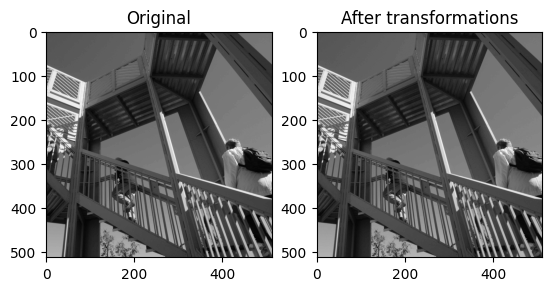

In [11]:
tst_img = misc.ascent()
recover = encode_decode_img(tst_img)

# visual test
show_compare(tst_img,recover)

# Exercitiul 2

C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\2796848043.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  tst_img = misc.face()


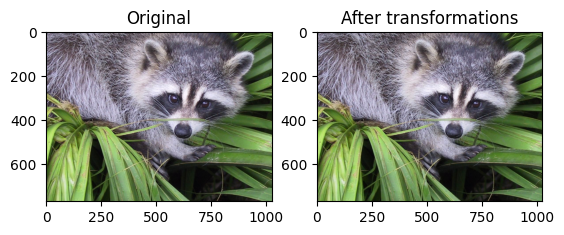

In [12]:
tst_img = misc.face()
recover = encode_decode_img_rgb(tst_img)

# visual test
show_compare(tst_img,recover)

C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\3559941229.py:3: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face() # raton <3


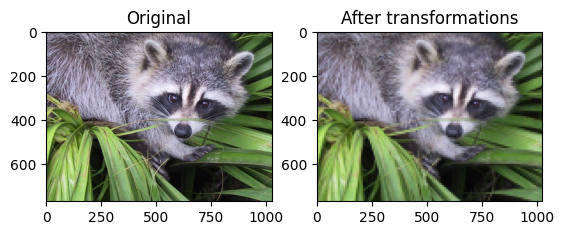

In [13]:
# just to see the effects of encoding
JpegEncoder.set_compression(14)
X = misc.face() # raton <3

jpeged = X

jpeged = encode_decode_img_rgb(jpeged)

show_compare(X,jpeged)

In [14]:
def mse(arr1,arr2):
    return mean_squared_error(arr1.flatten(),arr2.flatten()) # this expects <= 2 dim for some reason 

# grayscale
def mse_on_img(img):
    recover = encode_decode_img(img)
    return mse(img,recover)

# rgb color
def mse_on_img_rgb(img):
    recover = encode_decode_img_rgb(img)
    return mse(img,recover)

# Exercitiul 3

In [15]:
def configure_encoder_max_error_rgb(img,max_error):
    JpegEncoder.set_compression(0)
    min_err = mse_on_img_rgb(img)

    if min_err > max_error:
        print("Sorry we cant achieve that error :(")
        return
    
    lastok = 0
    for comp in range(1,2 * block_size - 1):
        JpegEncoder.set_compression(comp)
        error = mse_on_img_rgb(img)
        if error <= max_error:
            lastok = comp
        else:
            break
    print(f"Configuring encoder for {lastok} compression")
    JpegEncoder.set_compression(lastok)


C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\4017713223.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face()


Configuring encoder for 10 compression


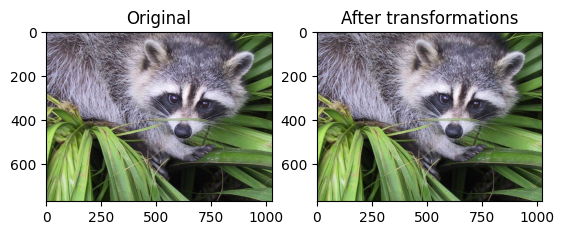

In [16]:
X = misc.face()
configure_encoder_max_error_rgb(X,25)

jpeged = encode_decode_img_rgb(X)

show_compare(X,jpeged)

C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\2735204835.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face()


Configuring encoder for 14 compression


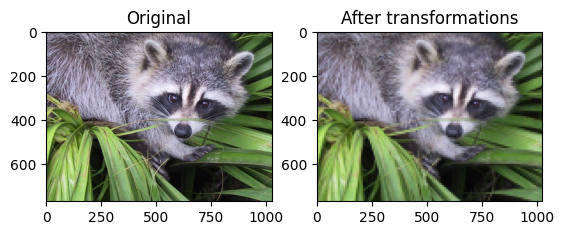

In [17]:
X = misc.face()
configure_encoder_max_error_rgb(X,100) # will look fried

jpeged = encode_decode_img_rgb(X)

show_compare(X,jpeged)

In [24]:
import huffman
import json
from collections import Counter

class HuffmanEncoder:
    def __init__(self, array):
        self.original_shape = array.shape
        self.array = array.flatten().astype(np.uint8)
        self.encoded_data = None
        self.codebook = None

    def encode(self):
        freq = Counter(self.array)
        self.codebook = huffman.codebook(freq.items())
        self.encoded_data = ''.join(self.codebook[value] for value in self.array)

    def write_to_file(self, filename, data):
        with open(filename, 'w') as file:
            file.write(data)

    def read_from_file(self, filename):
        with open(filename, 'r') as file:
            return file.read()

    def save_encoded_data(self, encoded_file, codebook_file):
        json_codebook = {str(key): val for key, val in self.codebook.items()}
        self.write_to_file(encoded_file, self.encoded_data)
        self.write_to_file(codebook_file, json.dumps(json_codebook))

    def load_encoded_data(self, encoded_file, codebook_file):
        read_encoded_data = self.read_from_file(encoded_file)
        read_codebook = json.loads(self.read_from_file(codebook_file))
        int_codebook = {int(key): val for key, val in read_codebook.items()}
        return read_encoded_data, int_codebook

    def decode(self, encoded_data, codebook):
        reverse_codebook = {code: value for value, code in codebook.items()}
        decoded_data = []
        current_code = ""
        for bit in encoded_data:
            current_code += bit
            if current_code in reverse_codebook:
                decoded_data.append(reverse_codebook[current_code])
                current_code = ""
        return np.array(decoded_data, dtype=np.uint8).reshape(self.original_shape)


In [28]:
OUT="mem_test/"

C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\2262503055.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face()


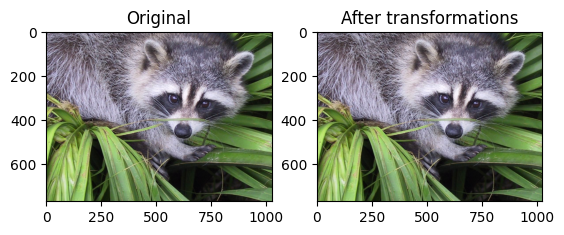

In [32]:
# test huffman compression
X = misc.face()

encoder = HuffmanEncoder(X)
encoder.encode()

encoded_file = f'{OUT}huffman_data.txt'
codebook_file = f'{OUT}codebook.json'
encoder.save_encoded_data(encoded_file, codebook_file)

read_encoded_data, read_codebook = encoder.load_encoded_data(encoded_file, codebook_file)
restored_X = encoder.decode(read_encoded_data, read_codebook)

show_compare(X,restored_X)

C:\Users\aairinei\AppData\Local\Temp\ipykernel_23052\1767496908.py:2: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  X = misc.face()


(96, 128, 64, 3)


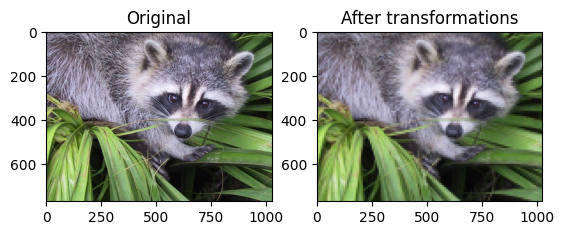

In [36]:
# Write to file(s) to checkout compression
X = misc.face()
JpegEncoder.set_compression(14) # adjust to see different compression

encoded = JpegEncoder.jpeg_rgb(X)
print(encoded.shape)

encoder = HuffmanEncoder(encoded)
encoder.encode()

encoded_file = f'{OUT}jpeg_huffman_data.txt'
codebook_file = f'{OUT}jpeg_codebook.json'
encoder.save_encoded_data(encoded_file, codebook_file)

read_encoded_data, read_codebook = encoder.load_encoded_data(encoded_file, codebook_file)
restored_array = encoder.decode(read_encoded_data, read_codebook)

restored_X = JpegDecoder.unjpeg_rgb(encoded)

show_compare(X,restored_X)